In [89]:
import torch
from transformers import BertModel, BertTokenizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score


In [90]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

#function to get CLS embeddings of sentences (stimuli)

def get_cls_embeddings(sentences):
    
    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer.encode(sent, add_special_tokens=True)
        input_ids.append(encoded_sent)
    
    
    max_len = max([len(sent) for sent in input_ids])
    input_ids = [sent + [0]*(max_len-len(sent)) for sent in input_ids]
    

    input_ids = torch.tensor(input_ids)
    
    
    with torch.no_grad():
        outputs = model(input_ids)
        cls_embeddings = outputs[0][:, 0, :]
    
    return cls_embeddings.numpy()


#function to get pooled embeddings of sentences (stimuli)

def get_pooled_embeddings(sentences):
    # Tokenize input sentences and add special tokens [CLS] and [SEP]
    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer.encode(sent, add_special_tokens=True)
        input_ids.append(encoded_sent)
    
    # Pad input sequences to the same length
    max_len = max([len(sent) for sent in input_ids])
    input_ids = [sent + [0]*(max_len-len(sent)) for sent in input_ids]
    
    # Convert input sequences to PyTorch tensors
    input_ids = torch.tensor(input_ids)
    
    # Pass input sequences through BERT model to get pooled embeddings
    with torch.no_grad():
        outputs = model(input_ids)
        pooled_embeddings = outputs[1]
    
    return pooled_embeddings.numpy()



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [91]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

def get_GloVe_encodings(sentences):
    sentence_embeddings = []
    for sentence in sentences:
        embedding_dim = 100 
        sentence_embedding = np.zeros((embedding_dim,))
        num_words = 0
        for word in sentence:
            if word in embeddings_index:
                sentence_embedding += embeddings_index[word]
                num_words += 1
        if num_words > 0:
            sentence_embedding /= num_words
        
        sentence_embeddings.append(sentence_embedding)
        
    return sentence_embeddings

In [92]:
stimuli =[]

with open('stimuli.txt', 'r') as f:
    for line in f:
        stimuli.append(line.strip())

# get CLS embeddings of stimuli
cls_embeddings = get_cls_embeddings(stimuli)

# get pooled embeddings of stimuli
pooled_embeddings = get_pooled_embeddings(stimuli)

# get GloVe embeddings of stimuli

glove_embeddings = get_GloVe_encodings(stimuli)




In [93]:
subj1 = np.load("subj1.npy", allow_pickle=True).item()
subj2 = np.load("subj2.npy", allow_pickle=True).item()

In [94]:
subj1.keys()

dict_keys(['language', 'vision', 'dmn', 'task'])

In [95]:
subj1['language'].shape

(627, 11437)

In [96]:
cls_embeddings.shape

(627, 768)

In [97]:
def pearson_corr(x, y):
    
    pearson_corr=[]
    for i in range(len(x)):
        pearson_corr.append(np.corrcoef(x[i], y[i])[0][1])
    
    return np.mean(pearson_corr)


def _2v2_Accuracy(y_test, y_pred):
    cs_dist = cosine_distances(y_test, y_pred)
    value = 0
    for i in range(0, len(y_test)-1):
        for j in range(i+1, len(y_test)):
            a = cs_dist[i, i]+cs_dist[j,j]
            b = cs_dist[i,j]+cs_dist[j,i]
            if (a<b):
                value += 1  
    value /= (len(y_test)*(len(y_test)-1)/2)
    return value




In [98]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


def k_fold_cross_validation(X, y, model, k=10, random_state=None):

    # Split the data into k folds
    fold_size = len(y) // k
    folds_X = [X[i*fold_size:(i+1)*fold_size] for i in range(k)]
    folds_y = [y[i*fold_size:(i+1)*fold_size] for i in range(k)]
    
    p_c = []
    _2v2_accuracy = []
    
    # Perform k-fold cross-validation
    for i in range(k):
        X_test, y_test = folds_X[i], folds_y[i]
        X_train = np.concatenate(folds_X[:i] + folds_X[i+1:])
        y_train = np.concatenate(folds_y[:i] + folds_y[i+1:])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        p_c.append(pearson_corr(y_test, y_pred))
        _2v2_accuracy.append(_2v2_Accuracy(y_test, y_pred))
          
    return (sum(p_c)/len(p_c)), (sum(_2v2_accuracy)/len(_2v2_accuracy))


In [117]:

subj1_lang_pearson_corr_CLS, subj1_lang_2v2_acc_CLS = k_fold_cross_validation(subj1['language'], cls_embeddings, Ridge(), k=10, random_state=None)
subj1_lang_pearson_corr_pooled, subj1_lang_2v2_acc_pooled = k_fold_cross_validation(subj1['language'], pooled_embeddings, Ridge(), k=10, random_state=None)
subj1_lang_pearson_corr_glove, subj1_lang_2v2_acc_glove = k_fold_cross_validation(subj1['language'], glove_embeddings, Ridge(), k=10, random_state=None)

subj1_vision_pearson_corr_CLS, subj1_vision_2v2_acc_CLS = k_fold_cross_validation(subj1['vision'], cls_embeddings, Ridge(), k=10, random_state=None)
subj1_vision_pearson_corr_pooled, subj1_vision_2v2_acc_pooled = k_fold_cross_validation(subj1['vision'], pooled_embeddings, Ridge(), k=10, random_state=None)
subj1_vision_pearson_corr_glove, subj1_vision_2v2_acc_glove = k_fold_cross_validation(subj1['vision'], glove_embeddings, Ridge(), k=10, random_state=None)

subj1_dmn_pearson_corr_CLS, subj1_dmn_2v2_acc_CLS = k_fold_cross_validation(subj1['dmn'], cls_embeddings, Ridge(), k=10, random_state=None)
subj1_dmn_pearson_corr_pooled, subj1_dmn_2v2_acc_pooled = k_fold_cross_validation(subj1['dmn'], pooled_embeddings, Ridge(), k=10, random_state=None)
subj1_dmn_pearson_corr_glove, subj1_dmn_2v2_acc_glove = k_fold_cross_validation(subj1['dmn'], glove_embeddings, Ridge(), k=10, random_state=None)

subj1_task_pearson_corr_CLS, subj1_task_2v2_acc_CLS = k_fold_cross_validation(subj1['task'], cls_embeddings, Ridge(), k=10, random_state=None)
subj1_task_pearson_corr_pooled, subj1_task_2v2_acc_pooled = k_fold_cross_validation(subj1['task'], pooled_embeddings, Ridge(), k=10, random_state=None)
subj1_task_pearson_corr_glove, subj1_task_2v2_acc_glove = k_fold_cross_validation(subj1['task'], glove_embeddings, Ridge(), k=10, random_state=None)

subj2_lang_pearson_corr_CLS, subj2_lang_2v2_acc_CLS = k_fold_cross_validation(subj2['language'], cls_embeddings, Ridge(), k=10, random_state=None)
subj2_lang_pearson_corr_pooled, subj2_lang_2v2_acc_pooled = k_fold_cross_validation(subj2['language'], pooled_embeddings, Ridge(), k=10, random_state=None)
subj2_lang_pearson_corr_glove, subj2_lang_2v2_acc_glove = k_fold_cross_validation(subj2['language'], glove_embeddings, Ridge(), k=10, random_state=None)

subj2_vision_pearson_corr_CLS, subj2_vision_2v2_acc_CLS = k_fold_cross_validation(subj2['vision'], cls_embeddings, Ridge(), k=10, random_state=None)
subj2_vision_pearson_corr_pooled, subj2_vision_2v2_acc_pooled = k_fold_cross_validation(subj2['vision'], pooled_embeddings, Ridge(), k=10, random_state=None)
subj2_vision_pearson_corr_glove, subj2_vision_2v2_acc_glove = k_fold_cross_validation(subj2['vision'], glove_embeddings, Ridge(), k=10, random_state=None)

subj2_dmn_pearson_corr_CLS, subj2_dmn_2v2_acc_CLS = k_fold_cross_validation(subj2['dmn'], cls_embeddings, Ridge(), k=10, random_state=None)
subj2_dmn_pearson_corr_pooled, subj2_dmn_2v2_acc_pooled = k_fold_cross_validation(subj2['dmn'], pooled_embeddings, Ridge(), k=10, random_state=None)
subj2_dmn_pearson_corr_glove, subj2_dmn_2v2_acc_glove = k_fold_cross_validation(subj2['dmn'], glove_embeddings, Ridge(), k=10, random_state=None)

subj2_task_pearson_corr_CLS, subj2_task_2v2_acc_CLS = k_fold_cross_validation(subj2['task'], cls_embeddings, Ridge(), k=10, random_state=None)
subj2_task_pearson_corr_pooled, subj2_task_2v2_acc_pooled = k_fold_cross_validation(subj2['task'], pooled_embeddings, Ridge(), k=10, random_state=None)
subj2_task_pearson_corr_glove, subj2_task_2v2_acc_glove = k_fold_cross_validation(subj2['task'], glove_embeddings, Ridge(), k=10, random_state=None)


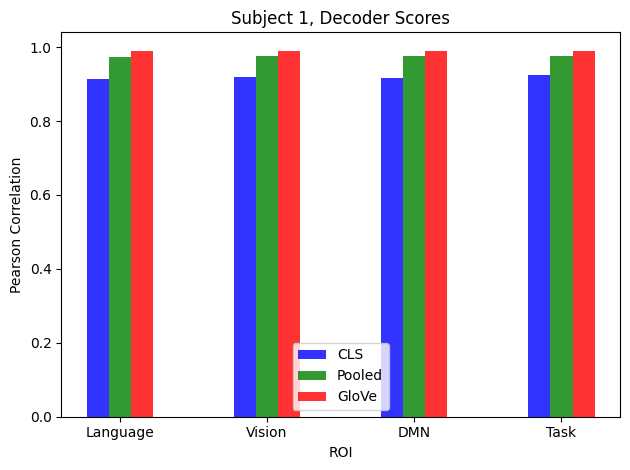

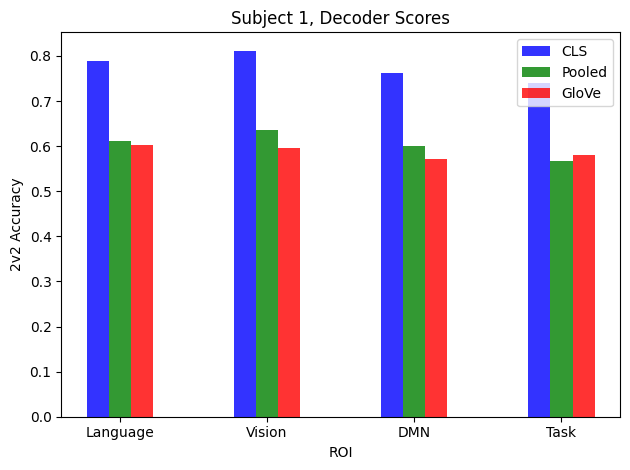

In [114]:
#plot a  bar graph with x x-axis as different ROIs (language, vision, dmn, task) and y-axis as pearson correlation and 2v2 accuracy for CLS, pooled embeddings and 

import matplotlib.pyplot as plt

# data to plot

n_groups = 4

pearson_corr_CLS = (subj1_lang_pearson_corr_CLS, subj1_vision_pearson_corr_CLS, subj1_dmn_pearson_corr_CLS, subj1_task_pearson_corr_CLS)
pearson_corr_pooled = (subj1_lang_pearson_corr_pooled, subj1_vision_pearson_corr_pooled, subj1_dmn_pearson_corr_pooled, subj1_task_pearson_corr_pooled)
pearson_corr_glove = (subj1_lang_pearson_corr_glove, subj1_vision_pearson_corr_glove, subj1_dmn_pearson_corr_glove, subj1_task_pearson_corr_glove)


_2v2_acc_CLS = (subj1_lang_2v2_acc_CLS, subj1_vision_2v2_acc_CLS, subj1_dmn_2v2_acc_CLS, subj1_task_2v2_acc_CLS)
_2v2_acc_pooled = (subj1_lang_2v2_acc_pooled, subj1_vision_2v2_acc_pooled, subj1_dmn_2v2_acc_pooled, subj1_task_2v2_acc_pooled)
_2v2_acc_glove = (subj1_lang_2v2_acc_glove, subj1_vision_2v2_acc_glove, subj1_dmn_2v2_acc_glove, subj1_task_2v2_acc_glove)

# create plot

fig, ax = plt.subplots()

index = np.arange(n_groups)

bar_width = 0.15

opacity = 0.8

rects1 = plt.bar(index, pearson_corr_CLS, bar_width,

alpha=opacity,

color='b',

label='CLS')

rects2 = plt.bar(index + bar_width, pearson_corr_pooled, bar_width,

alpha=opacity,

color='g',

label='Pooled')

rects3 = plt.bar(index + 2*bar_width, pearson_corr_glove, bar_width,

alpha=opacity,

color='r',

label='GloVe')

plt.xlabel('ROI')

plt.ylabel('Pearson Correlation')

plt.title('Subject 1, Decoder Scores')

plt.xticks(index + bar_width, ('Language', 'Vision', 'DMN', 'Task'))

plt.legend()

plt.tight_layout()

plt.show()



fig, ax = plt.subplots()

index = np.arange(n_groups)

bar_width = 0.15

opacity = 0.8

rects1 = plt.bar(index, _2v2_acc_CLS, bar_width,
                 
                    alpha=opacity,

                    color='b',

                    label='CLS')

rects2 = plt.bar(index + bar_width, _2v2_acc_pooled, bar_width,
                 
                    alpha=opacity,

                    color='g',

                    label='Pooled')

rects3 = plt.bar(index + 2*bar_width, _2v2_acc_glove, bar_width,
                 
                    alpha=opacity,

                    color='r',

                    label='GloVe')

plt.xlabel('ROI')

plt.ylabel('2v2 Accuracy')

plt.title('Subject 1, Decoder Scores')

plt.xticks(index + bar_width, ('Language', 'Vision', 'DMN', 'Task'))

plt.legend()

plt.tight_layout()

plt.show()



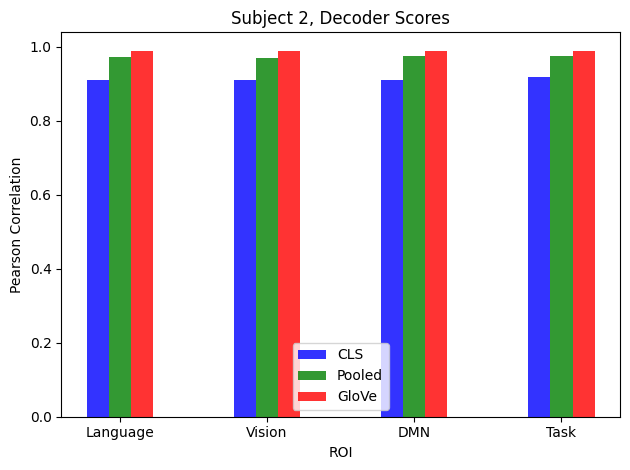

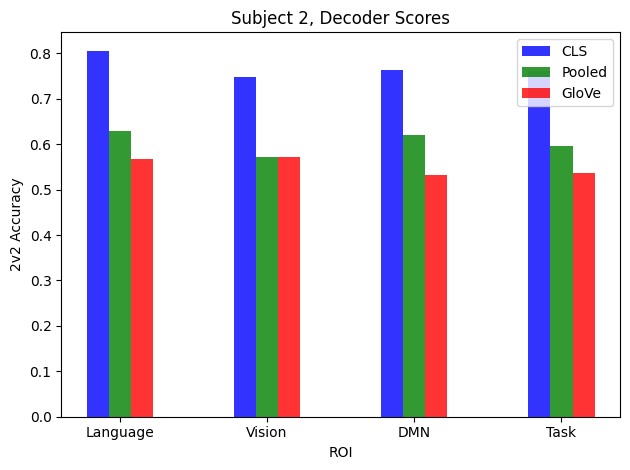

In [115]:
#Do the same as above for subject 2

#plot a  bar graph with x x-axis as different ROIs (language, vision, dmn, task) and y-axis as pearson correlation and 2v2 accuracy for CLS, pooled embeddings and

import matplotlib.pyplot as plt

# data to plot

n_groups = 4

pearson_corr_CLS = (subj2_lang_pearson_corr_CLS, subj2_vision_pearson_corr_CLS, subj2_dmn_pearson_corr_CLS, subj2_task_pearson_corr_CLS)
pearson_corr_pooled = (subj2_lang_pearson_corr_pooled, subj2_vision_pearson_corr_pooled, subj2_dmn_pearson_corr_pooled, subj2_task_pearson_corr_pooled)
pearson_corr_glove = (subj2_lang_pearson_corr_glove, subj2_vision_pearson_corr_glove, subj2_dmn_pearson_corr_glove, subj2_task_pearson_corr_glove)

_2v2_acc_CLS = (subj2_lang_2v2_acc_CLS, subj2_vision_2v2_acc_CLS, subj2_dmn_2v2_acc_CLS, subj2_task_2v2_acc_CLS)
_2v2_acc_pooled = (subj2_lang_2v2_acc_pooled, subj2_vision_2v2_acc_pooled, subj2_dmn_2v2_acc_pooled, subj2_task_2v2_acc_pooled)
_2v2_acc_glove = (subj2_lang_2v2_acc_glove, subj2_vision_2v2_acc_glove, subj2_dmn_2v2_acc_glove, subj2_task_2v2_acc_glove)

# create plot

fig, ax = plt.subplots()

index = np.arange(n_groups)

bar_width = 0.15

opacity = 0.8

rects1 = plt.bar(index, pearson_corr_CLS, bar_width,

alpha=opacity,

color='b',

label='CLS')

rects2 = plt.bar(index + bar_width, pearson_corr_pooled, bar_width,

alpha=opacity,

color='g',

label='Pooled')

rects3 = plt.bar(index + 2*bar_width, pearson_corr_glove, bar_width,

alpha=opacity,

color='r',

label='GloVe')

plt.xlabel('ROI')

plt.ylabel('Pearson Correlation')

plt.title('Subject 2, Decoder Scores')

plt.xticks(index + bar_width, ('Language', 'Vision', 'DMN', 'Task'))

plt.legend()

plt.tight_layout()

plt.show()

fig, ax = plt.subplots()

index = np.arange(n_groups)

bar_width = 0.15

opacity = 0.8

rects1 = plt.bar(index, _2v2_acc_CLS, bar_width,
                 
                    alpha=opacity,

                    color='b',

                    label='CLS')

rects2 = plt.bar(index + bar_width, _2v2_acc_pooled, bar_width,
                 
                    alpha=opacity,

                    color='g',

                    label='Pooled')

rects3 = plt.bar(index + 2*bar_width, _2v2_acc_glove, bar_width,
                 
                    alpha=opacity,

                    color='r',

                    label='GloVe')

plt.xlabel('ROI')

plt.ylabel('2v2 Accuracy')

plt.title('Subject 2, Decoder Scores')

plt.xticks(index + bar_width, ('Language', 'Vision', 'DMN', 'Task'))

plt.legend()

plt.tight_layout()

plt.show()




In [119]:
subj1_lang_pearson_corr_CLS, subj1_lang_2v2_acc_CLS = k_fold_cross_validation(cls_embeddings,subj1['language'], Ridge(), k=10, random_state=None)
subj1_lang_pearson_corr_pooled, subj1_lang_2v2_acc_pooled = k_fold_cross_validation(pooled_embeddings, subj1['language'],  Ridge(), k=10, random_state=None)
subj1_lang_pearson_corr_glove, subj1_lang_2v2_acc_glove = k_fold_cross_validation(glove_embeddings, subj1['language'],  Ridge(), k=10, random_state=None)

subj1_vision_pearson_corr_CLS, subj1_vision_2v2_acc_CLS = k_fold_cross_validation(cls_embeddings, subj1['vision'],  Ridge(), k=10, random_state=None)
subj1_vision_pearson_corr_pooled, subj1_vision_2v2_acc_pooled = k_fold_cross_validation(pooled_embeddings, subj1['vision'],  Ridge(), k=10, random_state=None)
subj1_vision_pearson_corr_glove, subj1_vision_2v2_acc_glove = k_fold_cross_validation(glove_embeddings, subj1['vision'],  Ridge(), k=10, random_state=None)

subj1_dmn_pearson_corr_CLS, subj1_dmn_2v2_acc_CLS = k_fold_cross_validation(cls_embeddings, subj1['dmn'],  Ridge(), k=10, random_state=None)
subj1_dmn_pearson_corr_pooled, subj1_dmn_2v2_acc_pooled = k_fold_cross_validation(pooled_embeddings, subj1['dmn'],  Ridge(), k=10, random_state=None)
subj1_dmn_pearson_corr_glove, subj1_dmn_2v2_acc_glove = k_fold_cross_validation(glove_embeddings, subj1['dmn'],  Ridge(), k=10, random_state=None)

subj1_task_pearson_corr_CLS, subj1_task_2v2_acc_CLS = k_fold_cross_validation(cls_embeddings, subj1['task'],  Ridge(), k=10, random_state=None)
subj1_task_pearson_corr_pooled, subj1_task_2v2_acc_pooled = k_fold_cross_validation(pooled_embeddings, subj1['task'],  Ridge(), k=10, random_state=None)
subj1_task_pearson_corr_glove, subj1_task_2v2_acc_glove = k_fold_cross_validation(glove_embeddings, subj1['task'],  Ridge(), k=10, random_state=None)

subj2_lang_2v2_acc_CLS, subj2_lang_pearson_corr_CLS = k_fold_cross_validation(cls_embeddings, subj2['language'],  Ridge(), k=10, random_state=None)
subj2_lang_2v2_acc_pooled, subj2_lang_pearson_corr_pooled = k_fold_cross_validation(pooled_embeddings, subj2['language'],  Ridge(), k=10, random_state=None)
subj2_lang_2v2_acc_glove, subj2_lang_pearson_corr_glove = k_fold_cross_validation(glove_embeddings, subj2['language'],  Ridge(), k=10, random_state=None)

subj2_vision_2v2_acc_CLS, subj2_vision_pearson_corr_CLS = k_fold_cross_validation(cls_embeddings, subj2['vision'],  Ridge(), k=10, random_state=None)
subj2_vision_2v2_acc_pooled, subj2_vision_pearson_corr_pooled = k_fold_cross_validation(pooled_embeddings, subj2['vision'],  Ridge(), k=10, random_state=None)
subj2_vision_2v2_acc_glove, subj2_vision_pearson_corr_glove = k_fold_cross_validation(glove_embeddings, subj2['vision'],  Ridge(), k=10, random_state=None)

subj2_dmn_2v2_acc_CLS, subj2_dmn_pearson_corr_CLS = k_fold_cross_validation(cls_embeddings, subj2['dmn'],  Ridge(), k=10, random_state=None)
subj2_dmn_2v2_acc_pooled, subj2_dmn_pearson_corr_pooled = k_fold_cross_validation(pooled_embeddings, subj2['dmn'],  Ridge(), k=10, random_state=None)
subj2_dmn_2v2_acc_glove, subj2_dmn_pearson_corr_glove = k_fold_cross_validation(glove_embeddings, subj2['dmn'],  Ridge(), k=10, random_state=None)

subj2_task_2v2_acc_CLS, subj2_task_pearson_corr_CLS = k_fold_cross_validation(cls_embeddings, subj2['task'],  Ridge(), k=10, random_state=None)
subj2_task_2v2_acc_pooled, subj2_task_pearson_corr_pooled = k_fold_cross_validation(pooled_embeddings, subj2['task'],  Ridge(), k=10, random_state=None)
subj2_task_2v2_acc_glove, subj2_task_pearson_corr_glove = k_fold_cross_validation(glove_embeddings, subj2['task'],  Ridge(), k=10, random_state=None)




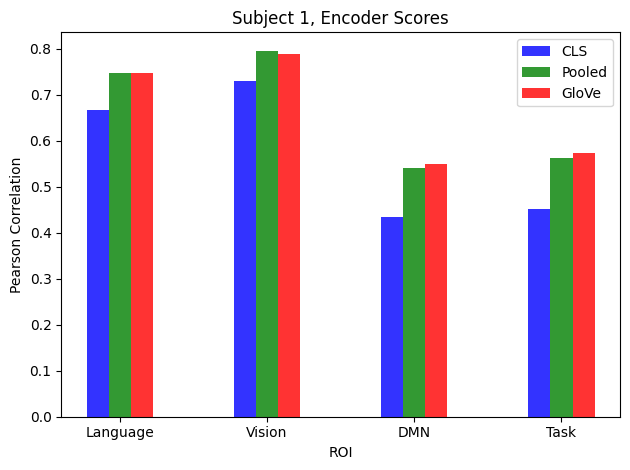

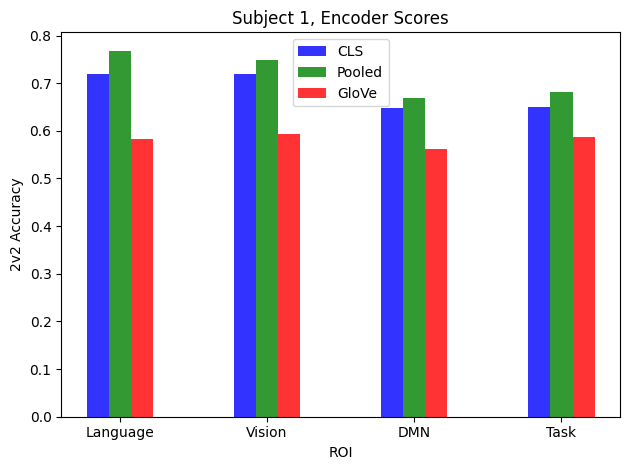

In [120]:
pearson_corr_CLS = (subj1_lang_pearson_corr_CLS, subj1_vision_pearson_corr_CLS, subj1_dmn_pearson_corr_CLS, subj1_task_pearson_corr_CLS)
pearson_corr_pooled = (subj1_lang_pearson_corr_pooled, subj1_vision_pearson_corr_pooled, subj1_dmn_pearson_corr_pooled, subj1_task_pearson_corr_pooled)
pearson_corr_glove = (subj1_lang_pearson_corr_glove, subj1_vision_pearson_corr_glove, subj1_dmn_pearson_corr_glove, subj1_task_pearson_corr_glove)

_2v2_acc_CLS = (subj1_lang_2v2_acc_CLS, subj1_vision_2v2_acc_CLS, subj1_dmn_2v2_acc_CLS, subj1_task_2v2_acc_CLS)
_2v2_acc_pooled = (subj1_lang_2v2_acc_pooled, subj1_vision_2v2_acc_pooled, subj1_dmn_2v2_acc_pooled, subj1_task_2v2_acc_pooled)
_2v2_acc_glove = (subj1_lang_2v2_acc_glove, subj1_vision_2v2_acc_glove, subj1_dmn_2v2_acc_glove, subj1_task_2v2_acc_glove)

n_groups = 4

fig, ax = plt.subplots()

index = np.arange(n_groups)

bar_width = 0.15

opacity = 0.8


rects1 = plt.bar(index, pearson_corr_CLS, bar_width,

alpha=opacity,

color='b',


label='CLS')

rects2 = plt.bar(index + bar_width, pearson_corr_pooled, bar_width,

alpha=opacity,

color='g',

label='Pooled')

rects3 = plt.bar(index + 2*bar_width, pearson_corr_glove, bar_width,

alpha=opacity,

color='r',

label='GloVe')

plt.xlabel('ROI')

plt.ylabel('Pearson Correlation')

plt.title('Subject 1, Encoder Scores')

plt.xticks(index + bar_width, ('Language', 'Vision', 'DMN', 'Task'))

plt.legend()

plt.tight_layout()

plt.show()


fig, ax = plt.subplots()

index = np.arange(n_groups)

bar_width = 0.15

opacity = 0.8

rects1 = plt.bar(index, _2v2_acc_CLS, bar_width,

alpha=opacity,

color='b',


label='CLS')

rects2 = plt.bar(index + bar_width, _2v2_acc_pooled, bar_width,
                 
alpha=opacity,

color='g',

label='Pooled')

rects3 = plt.bar(index + 2*bar_width, _2v2_acc_glove, bar_width,
                 
alpha=opacity,

color='r',

label='GloVe')

plt.xlabel('ROI')

plt.ylabel('2v2 Accuracy')

plt.title('Subject 1, Encoder Scores')

plt.xticks(index + bar_width, ('Language', 'Vision', 'DMN', 'Task'))

plt.legend()

plt.tight_layout()

plt.show()

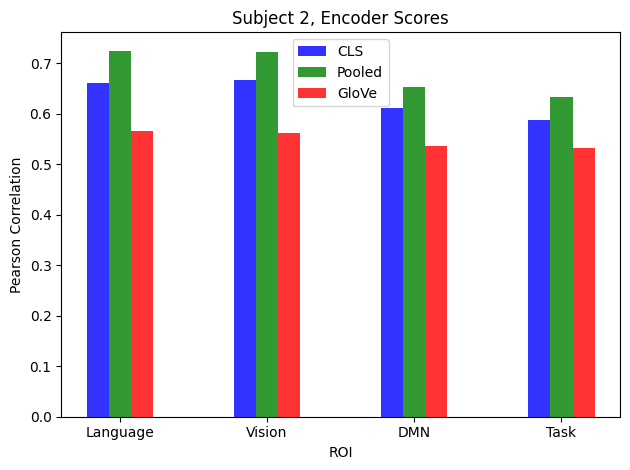

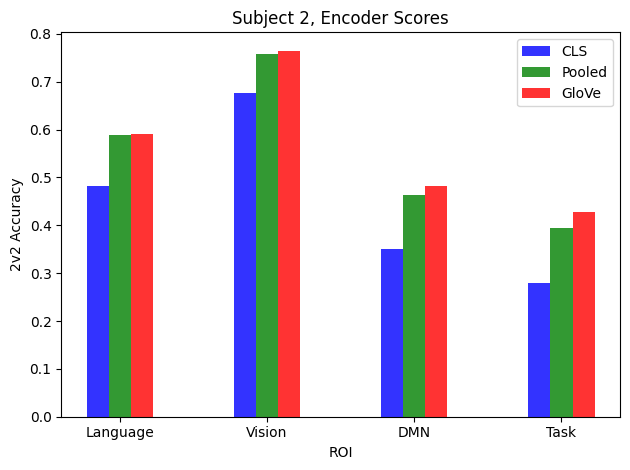

In [121]:
pearson_corr_CLS = (subj2_lang_pearson_corr_CLS, subj2_vision_pearson_corr_CLS, subj2_dmn_pearson_corr_CLS, subj2_task_pearson_corr_CLS)
pearson_corr_pooled = (subj2_lang_pearson_corr_pooled, subj2_vision_pearson_corr_pooled, subj2_dmn_pearson_corr_pooled, subj2_task_pearson_corr_pooled)
pearson_corr_glove = (subj2_lang_pearson_corr_glove, subj2_vision_pearson_corr_glove, subj2_dmn_pearson_corr_glove, subj2_task_pearson_corr_glove)

_2v2_acc_CLS = (subj2_lang_2v2_acc_CLS, subj2_vision_2v2_acc_CLS, subj2_dmn_2v2_acc_CLS, subj2_task_2v2_acc_CLS)
_2v2_acc_pooled = (subj2_lang_2v2_acc_pooled, subj2_vision_2v2_acc_pooled, subj2_dmn_2v2_acc_pooled, subj2_task_2v2_acc_pooled)
_2v2_acc_glove = (subj2_lang_2v2_acc_glove, subj2_vision_2v2_acc_glove, subj2_dmn_2v2_acc_glove, subj2_task_2v2_acc_glove)

n_groups = 4

fig, ax = plt.subplots()

index = np.arange(n_groups)

bar_width = 0.15

opacity = 0.8

rects1 = plt.bar(index, pearson_corr_CLS, bar_width,

alpha=opacity,

color='b',


label='CLS')

rects2 = plt.bar(index + bar_width, pearson_corr_pooled, bar_width,

alpha=opacity,

color='g',

label='Pooled')

rects3 = plt.bar(index + 2*bar_width, pearson_corr_glove, bar_width,

alpha=opacity,

color='r',

label='GloVe')

plt.xlabel('ROI')

plt.ylabel('Pearson Correlation')

plt.title('Subject 2, Encoder Scores')

plt.xticks(index + bar_width, ('Language', 'Vision', 'DMN', 'Task'))

plt.legend()

plt.tight_layout()

plt.show()


fig, ax = plt.subplots()

index = np.arange(n_groups)

bar_width = 0.15

opacity = 0.8

rects1 = plt.bar(index, _2v2_acc_CLS, bar_width,

alpha=opacity,

color='b',


label='CLS')

rects2 = plt.bar(index + bar_width, _2v2_acc_pooled, bar_width,
                 
alpha=opacity,

color='g',

label='Pooled')

rects3 = plt.bar(index + 2*bar_width, _2v2_acc_glove, bar_width,
                 
alpha=opacity,

color='r',

label='GloVe')

plt.xlabel('ROI')

plt.ylabel('2v2 Accuracy')

plt.title('Subject 2, Encoder Scores')

plt.xticks(index + bar_width, ('Language', 'Vision', 'DMN', 'Task'))

plt.legend()

plt.tight_layout()

plt.show()